* Prepared by Richard (Yu) Liu, 04/2025, https://scholar.google.com/citations?user=f8aS9_0AAAAJ&hl=en


# Imports

In [ ]:
!pip install botorch
!pip install gpytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
%matplotlib inline

In [2]:
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.pareto import is_non_dominated

import torch
import os

In [3]:
# AC-BO related packages

import torch

from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, LogExpectedImprovement
from gpytorch.distributions import MultivariateNormal
import gpytorch

import warnings
warnings.filterwarnings('ignore')

# from jax.lib import xla_bridge

# print(xla_bridge.get_backend().platform)

In [4]:
# AC-MOBO related packages

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement

from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.acquisition.multi_objective.monte_carlo import (
    qExpectedHypervolumeImprovement,
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex

import time
import warnings

# from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated

In [5]:
param = {
    "dtype": torch.float64,
    # "device": "cpu",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

print(param['device'])

cpu


# Appendix 1 -- simulation

## Define the problem

In [6]:
# 2D gaussian function
def gaussian_2d(x, y, p):
    '''
    p = [x0, y0, sigma_x, sigma_y, amplitude, theta]
    '''
    if len(np.shape(x)) == 1:
        x, y = np.meshgrid(x, y)
    x0, y0, sigma_x, sigma_y, amplitude, theta = p
    # Rotation matrix components
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    # Shift coordinates
    x_shifted = x - x0
    y_shifted = y - y0

    # Rotate coordinates
    x_rot = cos_theta * x_shifted + sin_theta * y_shifted
    y_rot = -sin_theta * x_shifted + cos_theta * y_shifted

    # 2D Gaussian formula
    exponent = -((x_rot**2 / (2 * sigma_x**2)) + (y_rot**2 / (2 * sigma_y**2)))
    return amplitude * np.exp(exponent)

In [8]:

def pareto_front_torch(f1, f2, mask_out=False):
    obj = torch.stack((torch.tensor(f1), torch.tensor(f2)), dim=-1)
    mask = is_non_dominated(obj)
    solutions = obj[mask].numpy()
    return (solutions, mask.numpy()) if mask_out else solutions

In [9]:
def reward1(x, y):
    return gaussian_2d(x, y, p=[0.35, 0.65, 0.25, 0.25, 1, 0]) +\
            gaussian_2d(x, y, p=[0.65, 0.35, 0.25, 0.25, -1, 0])

def reward2(x, y):
    return gaussian_2d(x, y, p=[0.35, 0.35, 0.25, 0.25, 1, 0]) +\
            gaussian_2d(x, y, p=[0.65, 0.65, 0.25, 0.25, -1, 0])

def measure(p1, p2):
    return np.array([reward1(p1, p2), reward2(p1, p2)])

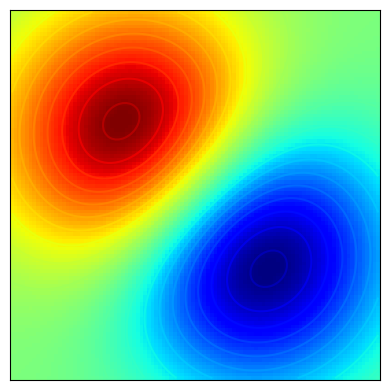

In [10]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)


rew1 = reward1(x, y)

plt.figure(figsize=[4,4])
im = plt.pcolormesh(x, y, rew1, cmap=plt.cm.jet)
plt.contour(x, y, rew1, levels=20, cmap=plt.cm.jet)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().set_frame_on(True)
plt.tight_layout()

# plt.savefig("output/rewards 1 without colobar.png", dpi=400, bbox_inches='tight',pad_inches=0.)

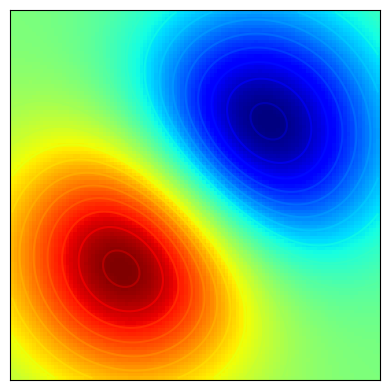

In [17]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
# x, y = np.meshgrid(x, y)

rew2 = reward2(x, y)

plt.figure(figsize=[4,4])
im = plt.pcolormesh(x, y, rew2, cmap=plt.cm.jet)
plt.contour(x, y, rew2, levels=20, cmap=plt.cm.jet)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().set_frame_on(True)
plt.tight_layout()
# plt.savefig("output/rewards 2 without colobar.png", dpi=400, bbox_inches='tight',pad_inches=0.)


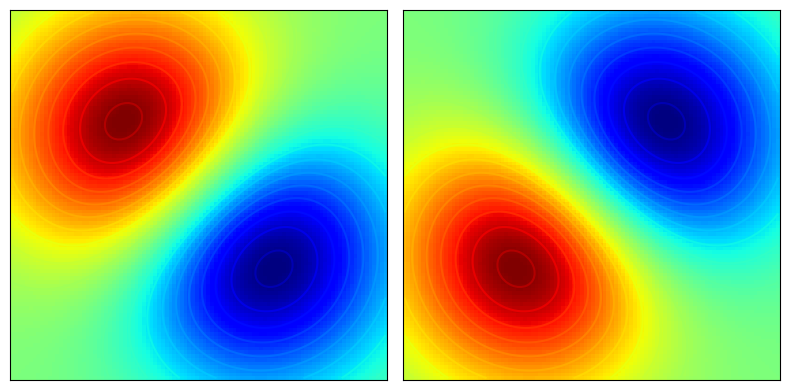

In [18]:
fig, ax = plt.subplots(1, 2, figsize=[8,4])
im1 = ax[0].pcolormesh(x, y, rew1, cmap=plt.cm.jet)
im2 = ax[1].pcolormesh(x, y, rew2, cmap=plt.cm.jet)
ax[0].contour(x, y, rew1, levels=20, cmap=plt.cm.jet)
ax[1].contour(x, y, rew2, levels=20, cmap=plt.cm.jet)

for axis in ax:
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    axis.set_frame_on(True)
plt.tight_layout()
# plt.savefig("output/rewards 2 without colobar.png", dpi=400, bbox_inches='tight',pad_inches=0.)


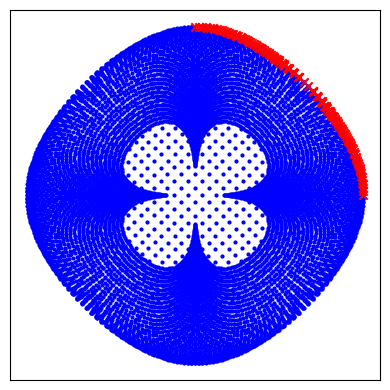

In [19]:
pareto1, mask1 = pareto_front_torch(rew1.flatten(), rew2.flatten(), mask_out=True)

plt.figure(figsize=[4,4])
plt.scatter(rew1.flatten(), rew2.flatten(), c='b', s=4)
plt.scatter(pareto1[:,0], pareto1[:,1], c='r', marker='x')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("output/rewards 1 vs 2.png", dpi=400, bbox_inches='tight',pad_inches=0.)


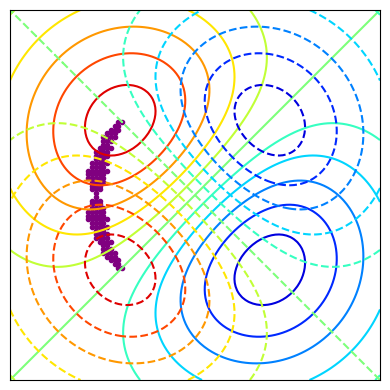

In [22]:
x_mesh, y_mesh = np.meshgrid(x, y)

plt.figure(figsize=[4,4])
plt.contour(x, y, rew1, levels=10, cmap=plt.cm.jet)
plt.contour(x, y, rew2, levels=10, cmap=plt.cm.jet, linestyles='dashed')

plt.scatter(x_mesh.flatten()[mask1], y_mesh.flatten()[mask1],  c='purple', marker='.')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.tight_layout()
# plt.savefig("output/pareto front in the parameter space.png", dpi=400, bbox_inches='tight',pad_inches=0.)


## Define the parameter space 

In [23]:
p1 = np.linspace(0, 1, 100)
p2 = np.linspace(0, 1, 100)

X = np.zeros([10000, 2])

for i in range(100):
    for j in range(100):
        X[100*i+j, 0] = p1[i]
        X[100*i+j, 1] = p2[j]

X_tensor = torch.from_numpy(X)
X_tensor

tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        ...,
        [1.0000, 0.9798],
        [1.0000, 0.9899],
        [1.0000, 1.0000]], dtype=torch.float64)

In [24]:
# 50 random seeding 

np.random.seed(35)
num = 50

idx = np.random.randint(0, len(X), num)

X_measured = X_tensor[idx]
y_measured = np.zeros([num, 2])

for i in range(num):
    y_measured[i] = measure(X_measured[i,0], X_measured[i,1])
    
y_measured = torch.from_numpy(y_measured)

In [25]:
# train the MOBO

acquisition='qNEHVI'
beta=4
delta=5
MC_SAMPLES = 128
N_BATCH = 20
BATCH_SIZE=1
NUM_RESTARTS = 10
EPSILON=0.05
RAW_SAMPLES = 512

train_x = X_measured.to(param['device'])
train_obj = y_measured.to(param['device'])

if len(train_x[0]) == 2:
    bounds = torch.stack([torch.ones(2), 1 * torch.ones(2)]).to(param['device'])
    standard_bounds = torch.zeros(2, 2, dtype=torch.float64).to(param['device'])
    standard_bounds[1] = 1
elif len(train_x[0]) == 3:
    bounds = torch.stack([torch.ones(3), 1 * torch.ones(3)]).to(param['device'])
    standard_bounds = torch.zeros(2, 3, dtype=torch.float64).to(param['device'])
    standard_bounds[1] = 1
else:
    print("Only 2 and 3 variables are supported!")

X = X_tensor.to(param['device'])

# Initialize the model
models = []
N = train_obj.shape[-1]
for i in range(train_obj.shape[-1]):
    train_y = train_obj[..., i : i + 1]
    models.append(
        SingleTaskGP(
            train_x, train_y, #outcome_transform=Standardize(m=1)
        )
    )
    
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_mll(mll)

# if sampler is None:
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

        
acq_func = qNoisyExpectedHypervolumeImprovement(
    model=model,
    ref_point = torch.tensor([0.25, 0.5]),
    X_baseline=normalize(train_x, bounds),
    prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
    sampler=sampler,
)


# optimize
candidates, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=standard_bounds,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    options={"batch_limit": 5, "maxiter": 200},
    sequential=True,
)

# predict over the unmeasured elements
x_list = [X] * N

# Evaluate the ModelListGP
model.eval()
outputs = model(*x_list)
pred = [posterior.mean.cpu().detach().numpy() for posterior in outputs]
# res_std =  [posterior.std.cpu().detach().numpy() for posterior in outputs]


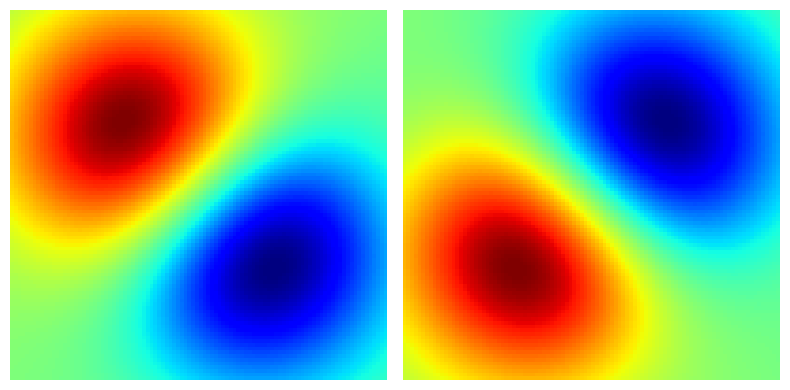

In [26]:
# Predicted rewards 

fig, ax = plt.subplots(1, 2, figsize=[8,4])
im1 = ax[0].pcolormesh(p1, p2, pred[0].reshape([100, 100]).T, cmap=plt.cm.jet)
im2 = ax[1].pcolormesh(p1, p2, pred[1].reshape([100, 100]).T, cmap=plt.cm.jet)

for axis in ax:
    axis.axes.get_xaxis().set_visible(False)
    axis.axes.get_yaxis().set_visible(False)
    axis.set_frame_on(False)
plt.tight_layout()
# plt.savefig("output/rewards 2 without colobar.png", dpi=400, bbox_inches='tight',pad_inches=0.)


## Shift the reference point

In [27]:
acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point = torch.tensor([0.5, 0.5]),
        X_baseline=normalize(train_x, bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    
    
# optimize
candidate0, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=standard_bounds,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    options={"batch_limit": 5, "maxiter": 200},
    sequential=True,
)

acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point = torch.tensor([0.1, 0.5]),
        X_baseline=normalize(train_x, bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    
    
# optimize
candidate1, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=standard_bounds,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    options={"batch_limit": 5, "maxiter": 200},
    sequential=True,
)

acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point = torch.tensor([0.5, 0.1]),
        X_baseline=normalize(train_x, bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    
    
# optimize
candidate2, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=standard_bounds,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    options={"batch_limit": 5, "maxiter": 200},
    sequential=True,
)


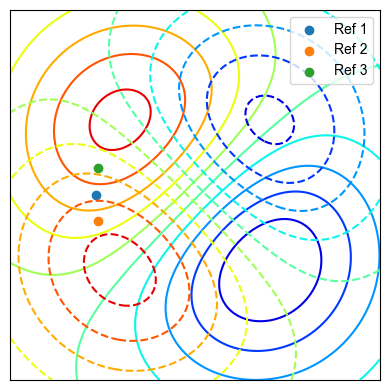

In [28]:
plt.figure(figsize=[4,4])

plt.contour(p1, p2, pred[0].reshape([100, 100]).T, levels=10, cmap=plt.cm.jet)
plt.contour(p1, p2, pred[1].reshape([100, 100]).T, levels=10, cmap=plt.cm.jet, linestyles='dashed')

plt.scatter(candidate0[:,0], candidate0[:,1], label='Ref 1')
plt.scatter(candidate1[:,0], candidate1[:,1], label='Ref 2')
plt.scatter(candidate2[:,0], candidate2[:,1], label='Ref 3')
plt.legend()

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
# plt.savefig("output/pareto front in the parameter space shifting reference points.png", dpi=400, bbox_inches='tight',pad_inches=0.)


## Add weight to the rewards

In [29]:
weights = np.linspace(0.75, 1.25 , 8)
weights

array([0.75      , 0.82142857, 0.89285714, 0.96428571, 1.03571429,
       1.10714286, 1.17857143, 1.25      ])

In [30]:
# train the MOBO

acquisition='qNEHVI'
beta=4
delta=5
MC_SAMPLES = 128
N_BATCH = 20
BATCH_SIZE=1
NUM_RESTARTS = 10
EPSILON=0.05
RAW_SAMPLES = 512

train_x = X_measured.to(param['device'])

candidates_weight = np.zeros([len(weights), 2])

for index in range(len(weights)):
    train_obj = y_measured.to(param['device']) 
    
    if len(train_x[0]) == 2:
        bounds = torch.stack([torch.ones(2), 1 * torch.ones(2)]).to(param['device'])
        standard_bounds = torch.zeros(2, 2, dtype=torch.float64).to(param['device'])
        standard_bounds[1] = 1
    elif len(train_x[0]) == 3:
        bounds = torch.stack([torch.ones(3), 1 * torch.ones(3)]).to(param['device'])
        standard_bounds = torch.zeros(2, 3, dtype=torch.float64).to(param['device'])
        standard_bounds[1] = 1
    else:
        print("Only 2 and 3 variables are supported!")
    
    X = X_tensor.to(param['device'])
    
    # Initialize the model
    models = []
    N = train_obj.shape[-1]
    for i in range(train_obj.shape[-1]):
        if not i:
            train_y = train_obj[..., i : i + 1] * weights[index]
        else:
            train_y = train_obj[..., i : i + 1] * 1
        models.append(
            SingleTaskGP(
                train_x, train_y, #outcome_transform=Standardize(m=1)
            )
        )
        
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    fit_gpytorch_mll(mll)
    
    # if sampler is None:
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point = torch.tensor([0.25, 0.25]),
        X_baseline=normalize(train_x, bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    
    
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    candidates_weight[index] = candidates

In [31]:
candidates_weight

array([[0.23201197, 0.51562288],
       [0.23177898, 0.50972165],
       [0.23173222, 0.50613157],
       [0.23162792, 0.50229564],
       [0.23160625, 0.50028392],
       [0.23156613, 0.4973108 ],
       [0.2315815 , 0.49340053],
       [0.23157487, 0.49583761]])

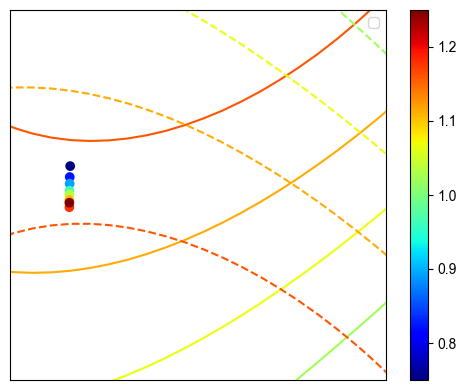

In [32]:
plt.figure(figsize=[5,4])
# im = plt.pcolormesh(x, y, g1+g2, cmap=plt.cm.jet)
plt.contour(p1, p2, pred[0].reshape([100, 100]).T, levels=10, cmap=plt.cm.jet)
plt.contour(p1, p2, pred[1].reshape([100, 100]).T, levels=10, cmap=plt.cm.jet, linestyles='dashed')

im = plt.scatter(candidates_weight[:,0], candidates_weight[:,1], c=weights, cmap=plt.cm.jet)
plt.colorbar(im, ax=plt.gca())
plt.legend()

plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlim(0.2, 0.4)
plt.ylim(0.4, 0.6)

plt.tight_layout()
# plt.savefig("output/pareto front in the parameter space added weights.png", dpi=400, bbox_inches='tight',pad_inches=0.)
